# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:

In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Implementation work

### Loading the data

In [31]:
train = pd.read_csv('./data/train.csv', dtype={
    'class_index': int, 'review_title': str, 'review_text': str
}).groupby('class_index').apply(lambda x: x.sample(2000))  # Sample data with all classes uniformly

test = pd.read_csv('./data/test.csv', dtype={
    'class_index': int, 'review_title': str, 'review_text': str
}).groupby('class_index').apply(lambda x: x.sample(400))  # Sample data with all classes uniformly

train.head()


class_index                     review_title  \
class_index                                                         
1           1064692            1  Did not connect to the Internet   
            740205             1                   Rubbish indeed   
            2087755            1                    I got a lemon   
            1485976            1                   The Visitation   
            1728556            1                Avoid this slicer   

                                                           review_text  
class_index                                                             
1           1064692  I got this card for a Sony vaio notebook adapt...  
            740205   Thought I'd give this guy Chopra a try. Cliche...  
            2087755  Less than 2 months after purchase the buttons ...  
            1485976  I was very disappointed in this book as it was...  
            1728556  I really don't see how this cheese slicer got ...

### Searching for null values

In [10]:
print("Columns with empty review text", len(train.loc[train['review_text'] == ""]))
print("Columns with missing review text", len(train.loc[train['review_text'] == None]))

print("Columns with empty review title", len(train.loc[train['review_title'] == ""]))
print("Columns with missing review title", len(train.loc[train['review_title'] == None]))

print("Columns with empty class index", len(train.loc[train['class_index'] == ""]))
print("Columns with missing class index", len(train.loc[train['class_index'] == None]))

Columns with empty review text 0
Columns with missing review text 0
Columns with empty review title 0
Columns with missing review title 0
Columns with empty class index 0
Columns with missing class index 0


As we can see, the dataset does not contain any empty or missing values

### Studying the data

<AxesSubplot:>

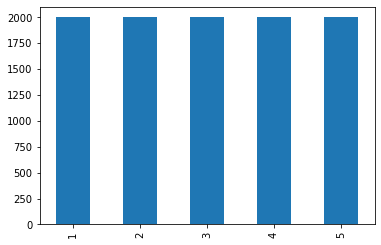

In [13]:
train['class_index'].value_counts().plot(kind='bar')

As the dataset creators have told us, the training dataset consists of 600 thousand rows for each review score, from 1 to 5. Since we've sampled it to 10 thousand samples evenly, we have 2 thousand rows for each review score.

##### Most frequent Words

/home/bruno/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

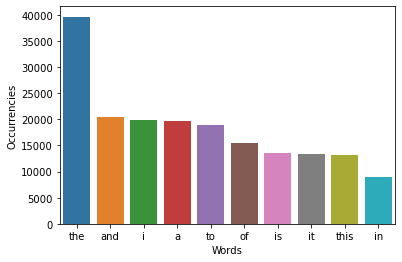

In [14]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['review_text']).lower().split()).value_counts()[:10]
mostUsedGraph = sb.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

### Treating the data
##### Cleanup and Normalization

In [37]:
negationTokens = ["not", "no", "nor", "never"]
ps = PorterStemmer()

def isNegative(word):
    return "n't" in word or word in negationTokens

def negateSequence(text):
    negation = False
    delims = "?.,!:;"
    result = []
    words = text.split()

    for word in words:
        stripped = word.strip(delims).lower()
        if negation and not isNegative(stripped):
            result.pop()
            result.append("not_" + stripped)
            negation = False
        else:
            result.append(stripped)

        if isNegative(stripped):
            negation = not negation

        if any(c in word for c in delims):
            negation = False

    return ' '.join(result)

def normalize(text):
    # treat negations as different tokens. Include ponctuation for context
    text = negateSequence(str(text))
    # remove non alpha chars
    text = re.sub('[^a-zA-Z0-9_]', ' ', text)
    # to lower-case and tokenize
    text = text.lower().split()
    # stemming and stop word removal
    text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

    return text

train['review_text'] = train['review_text'].apply(normalize)

train['review_title'] = train['review_title'].apply(normalize)
train.head()


test['review_text'] = test['review_text'].apply(normalize)
test['review_title'] = test['review_title'].apply(normalize)

##### Saving Preprocessed data
Since the original dataset is very large, we can sample it and save the preprocessed data in a different csv file, so it can be used later.

In [38]:
def savePreprocessedData(dataSet, fileName):
    dataSet.to_csv(fileName, index=False)

savePreprocessedData(train, './data/train_preprocessed.csv')
savePreprocessedData(test, './data/test_preprocessed.csv')

##### Generating wordclouds
A visually appealing way of observing words in a dataset is by showing wordclouds. In order to make a single wordcloud for a whole column, we can join all the cells together. We then pass it to WordCloud to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

These are the most common words in the reviews' titles:

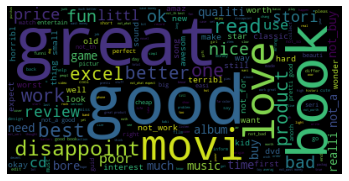

In [39]:
wordcloudTitle = WordCloud().generate(" ".join([str(x) for x in train['review_title'].values]))

plt.figure()
plt.imshow(wordcloudTitle)
plt.axis('off')
plt.show()

These are the most common words in the reviews' text:

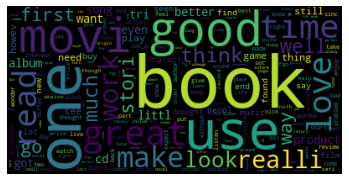

In [40]:
wordcloudText = WordCloud().generate(" ".join([str(x) for x in train['review_text'].values]))

plt.figure()
plt.imshow(wordcloudText)
plt.axis('off')
plt.show()

It would also be interesting to visualize a wordcloud for each of the reviews' classes (1 to 5):

Word cloud for class 1's titles:


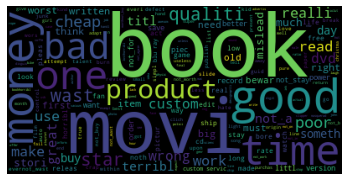

Word cloud for class 1's text:


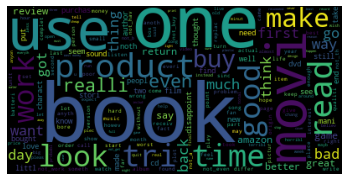

Word cloud for class 2's titles:


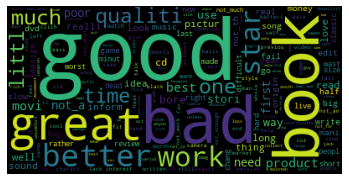

Word cloud for class 2's text:


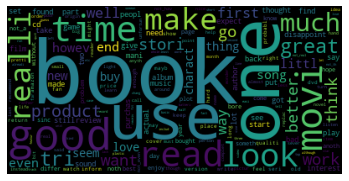

Word cloud for class 3's titles:


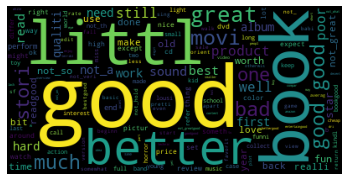

Word cloud for class 3's text:


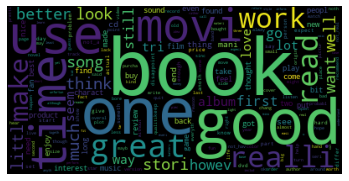

Word cloud for class 4's titles:


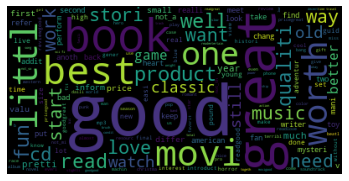

Word cloud for class 4's text:


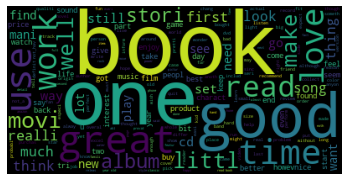

Word cloud for class 5's titles:


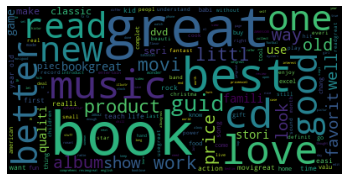

Word cloud for class 5's text:


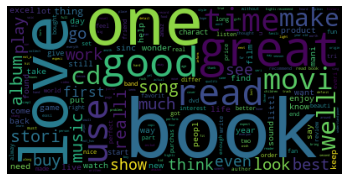

In [41]:
wordsPerClass = {
    1: ("", ""), # title and text
    2: ("", ""),
    3: ("", ""),
    4: ("", ""),
    5: ("", ""),
}

for i in range(len(train)):
    classId = int(train['class_index'].values[i])
    titleWords = train['review_title'].values[i]
    textWords = train['review_text'].values[i]
    
    wordsPerClass[classId] = (wordsPerClass[classId][0] + titleWords, wordsPerClass[classId][1] + textWords)

for i in range(1, 6):
    # Word cloud for class's titles
    wordcloudTitle = WordCloud().generate(wordsPerClass[i][0])
    print(f"Word cloud for class {i}'s titles:")

    plt.figure()
    plt.imshow(wordcloudTitle)
    plt.axis('off')
    plt.show()

    # Word cloud for class's text
    wordcloudText = WordCloud().generate(wordsPerClass[i][1])
    print(f"Word cloud for class {i}'s text:")

    plt.figure()
    plt.imshow(wordcloudText)
    plt.axis('off')
    plt.show()

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [42]:
train = pd.read_csv('./data/train_preprocessed.csv')
test = pd.read_csv('./data/test_preprocessed.csv')

vectorizer = CountVectorizer()

trainArr = map(str, train['review_title'])

titleWords = vectorizer.fit_transform(trainArr).toarray()

print(titleWords.shape)
print(vectorizer.get_feature_names())

(10000, 6745)
['00', '03', '05', '07', '08', '10', '100', '1000', '100x', '101', '106', '10th', '11', '111', '1190', '11g', '11th', '12', '120', '1205', '12g', '12v', '12x8', '13', '1331', '13th', '14', '15', '16', '160gb', '17', '170', '1731', '17bii', '18', '180', '180mm', '1933', '1939', '1940', '1954', '1973', '1980', '1989', '1996', '1997', '1998', '1999', '1ba', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2009', '2011', '2012', '202', '2048', '20d', '20x30', '21', '215', '23', '23460', '24', '25', '250', '28', '29th', '2ghz', '2nd', '2x', '30', '300', '3050', '31r', '32', '3200', '320kbp', '35', '360', '379ed', '38', '3com', '3d', '3eb', '3m', '3mile', '3mm', '3rd', '40', '400', '40oz', '40v3000', '411', '43', '450f', '48', '50', '500', '501bk', '508', '51', '520000', '530hcx', '55mm', '5891', '5ft', '5l', '60', '605', '60c', '60gb', '64mb', '655', '65533', '6mp', '6o', '6th', '70', '70th', '75', '757', '78', '7898', '79', '79537', '80', '

/home/bruno/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Obtaining the Test classes

In [43]:
y = train['class_index']

# print(X.shape, y.shape)

### Training Classifiers

In [44]:
clf = MultinomialNB()
clf.fit(titleWords, y)

testArr = map(str, test['review_title'])
testVector = vectorizer.transform(testArr).toarray()

y_pred = clf.predict(testVector)
print(y_pred)

[1 1 5 ... 5 3 4]


### Analyse Results

In [45]:
# confusion matrix
confusionMatrix = confusion_matrix(test['class_index'], y_pred)
print(confusionMatrix)

correctReviews = 0
for i in range(len(confusionMatrix)):
    correctReviews += confusionMatrix[i][i]

incorrectReviews = sum(map(sum, confusionMatrix)) - correctReviews
# print("correctReviews:", correctReviews)
# print("incorrectReviews:", incorrectReviews)

accuracy = (correctReviews / (incorrectReviews + correctReviews)) * 100

# accuracy, precision, recall, f1
# CHECK IF CONFUSION MATRIX IS ORDER FROM 1-5 RATING
print("Accuracy:", accuracy)
for i in range(5):
    colSum = 0
    for j in range(5):
        colSum += confusionMatrix[j][i]
    
    precision = (confusionMatrix[i][i] / colSum)
    recall = (confusionMatrix[i][i] / sum(confusionMatrix[i]))
    fMeasure = (2*precision*recall) / (precision + recall) 
    print("-------\n", i+1, "Rating Results:")
    print("Precision:", precision * 100, "%")
    print("Recall:", recall * 100, "%")
    print("F-measure:", fMeasure * 100, "%")

[[212  86  44  21  37]
 [114 115  88  37  46]
 [ 69  77 126  74  54]
 [ 49  34  77 125 115]
 [ 52  20  43  81 204]]
Accuracy: 39.1
-------
 1 Rating Results:
Precision: 42.74193548387097 %
Recall: 53.0 %
F-measure: 47.32142857142858 %
-------
 2 Rating Results:
Precision: 34.63855421686747 %
Recall: 28.749999999999996 %
F-measure: 31.420765027322407 %
-------
 3 Rating Results:
Precision: 33.33333333333333 %
Recall: 31.5 %
F-measure: 32.390745501285345 %
-------
 4 Rating Results:
Precision: 36.98224852071006 %
Recall: 31.25 %
F-measure: 33.87533875338754 %
-------
 5 Rating Results:
Precision: 44.73684210526316 %
Recall: 51.0 %
F-measure: 47.66355140186916 %
